## Literature to be classified

In [1]:
import pandas as pd
from typing import Dict
from os import path, makedirs
from tqdm.notebook import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, ZeroShotClassificationPipeline
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option("display.max_rows", 50)

## Dataset Helper Classes

In order to seamlessly use the created datasets, an adapter class and specific adapter classes are used

In [62]:
class ZeroShotDataset:
    def __init__(self, source_file, is_multi_label = False, custom_hypothesis="This text is about {}") -> None:
        self.source_file = source_file
        self._prepared_data: pd.DataFrame = None
        self.is_multi_label = is_multi_label
        self.custom_hypothesis = custom_hypothesis
        self._prepare()
    
    def _prepare(self):
        self._prepared_data = pd.DataFrame()

    def get_prepared_data(self):
        return self._prepared_data
    
    @staticmethod
    def zeros_like(df):
        new_df = df.copy()
        for col in new_df.columns[1:]:
            new_df[col].values[:] = 0
        return new_df

    def get_empty_data(self, single_label = True):
        return self.zeros_like(self.get_single_label_data() if single_label else self._prepared_data)

    def get_labels(self, single_label = True):
        return list(self.get_single_label_data().iloc[:, 1:].columns) if single_label else list(self._prepared_data.iloc[:, 1:].columns)
    
    def get_single_label_data(self):
        return self._prepared_data.loc[(self._prepared_data.sum(axis=1, numeric_only=True) == 1)]
    
    def get_raw_data(self):
        return pd.read_csv(self.source_file, sep=";", encoding='ISO-8859-1')
    
    def get_long_data(self):
        raise NotImplementedError("This method is not implemented for this dataset")

class AiInIsDataCollectionDataset(ZeroShotDataset):
    def __init__(self, custom_hypothesis="This text is about {}") -> None:
        super().__init__(
            "/home/jovyan/work/data/overviews/ai_in_is_data_collection_techniques_solutions.csv",
            is_multi_label = True,
            custom_hypothesis = custom_hypothesis
            )
    
    def _prepare(self):
        df = pd.read_csv(self.source_file, sep=";", encoding='ISO-8859-1')
        df = df.iloc[:, 3:]
        df = df.rename(columns={"ml subset selection": "machine learning subset selection"})
        self._prepared_data = df

    def get_single_label_data(self):
        df = super().get_single_label_data()
        df = df.drop("prediction markets", axis=1)
        return df
    
    def get_long_data(self):
        df = self.get_raw_data()
        df["labels"] = df.apply(lambda row: row[row == 1].index[0] , axis=1)
        df = df.drop("reference", axis=1)
        df = df[df.sum(axis=1, numeric_only=True) == 1]
        return df

class AiInIsTypesDataset(ZeroShotDataset):
    def __init__(self, custom_hypothesis="This text is about {}") -> None:
        super().__init__(
            "/home/jovyan/work/data/overviews/ai_in_is_types_solutions.csv",
            is_multi_label = False,
            custom_hypothesis = custom_hypothesis
            )
    
    def _prepare(self):
        df = pd.read_csv(self.source_file, sep=";", encoding='ISO-8859-1')
        df = df.iloc[:, 2:]
        df = pd.concat([df, df.type.str.get_dummies()], axis=1).drop("type", axis=1)
        self._prepared_data = df

    def get_long_data(self):
        df = self.get_raw_data()
        df = df.rename(columns={"type": "labels"})
        return df

class DataCompletenessInHealthcareDataset(ZeroShotDataset):
    def __init__(self, custom_hypothesis="This text is about {}") -> None:
        super().__init__(
            "/home/jovyan/work/data/overviews/data_completeness_in_healthcare_solutions.csv",
            is_multi_label = True,
            custom_hypothesis = custom_hypothesis
            )
    
    def _prepare(self):
        df = pd.read_csv(self.source_file, sep=";", encoding='ISO-8859-1')
        df = df.iloc[:, 2:]
        self._prepared_data = df

    def get_long_data(self):
        df = self.get_raw_data()
        df["labels"] = df.apply(lambda row: row[row == 1].index[0] , axis=1)
        df = df[df.sum(axis=1, numeric_only=True) == 1]
        return df

class MachineLearningInBusinessDataset(ZeroShotDataset):
    def __init__(self, custom_hypothesis="This text is about {}") -> None:
        super().__init__(
            "/home/jovyan/work/data/overviews/ml_in_business_solutions.csv",
            is_multi_label = False,
            custom_hypothesis = custom_hypothesis
            )
    
    def _prepare(self):
        df = pd.read_csv(self.source_file, sep=";", encoding='ISO-8859-1')
        df = df.iloc[:, 1:]
        df = pd.concat([df, df.category.str.get_dummies()], axis=1).drop("category", axis=1)
        self._prepared_data = df

    def get_long_data(self):
        df = self.get_raw_data()
        df = df.rename(columns={"category": "labels"})
        return df

class SearchEngineAdvertisingDataset(ZeroShotDataset):
    def __init__(self, custom_hypothesis="This text is about {}") -> None:
        super().__init__(
            "/home/jovyan/work/data/overviews/sea_topics_solutions.csv",
            is_multi_label = False,
            custom_hypothesis = custom_hypothesis
            )
    
    def _prepare(self):
        df = pd.read_csv(self.source_file, sep=";", encoding='ISO-8859-1')
        df = df.iloc[:, 2:]
        df = pd.concat([df, df.topic.str.get_dummies()], axis=1).drop("topic", axis=1)
        self._prepared_data = df

    def get_long_data(self):
        df = self.get_raw_data()
        df = df.rename(columns={"topic": "labels"})
        return df

class OverviewWiTheoryTypeDataset(ZeroShotDataset):
    def __init__(self, custom_hypothesis="This text is about {}") -> None:
        super().__init__(
            "/home/jovyan/work/data/overviews/overview_WI.csv",
            is_multi_label = False,
            custom_hypothesis = custom_hypothesis
            )
    
    def _prepare(self):
        df = pd.read_csv(self.source_file, sep=";", encoding='ISO-8859-1')
        df = df.iloc[:, 5:7]
        df = pd.concat([df, df.theory_type.str.get_dummies()], axis=1).drop("theory_type", axis=1)
        self._prepared_data = df

    def get_long_data(self):
        df = self.get_raw_data()
        df = df.rename(columns={"theory_type": "labels"})
        return df

class OverviewWiResearchMethodDataset(ZeroShotDataset):
    def __init__(self, custom_hypothesis="This text is about {}") -> None:
        super().__init__(
            "/home/jovyan/work/data/overviews/overview_WI.csv",
            is_multi_label = False,
            custom_hypothesis = custom_hypothesis
            )
    
    def _prepare(self):
        df = pd.read_csv(self.source_file, sep=";", encoding='ISO-8859-1')
        df = df[['abstract', 'research method']]
        df = pd.concat([df, df['research method'].str.get_dummies()], axis=1).drop("research method", axis=1)
        self._prepared_data = df

    def get_long_data(self):
        df = self.get_raw_data()
        df = df.rename(columns={"research method": "labels"})
        return df

class OverviewMisqTheoryTypesDataset(ZeroShotDataset):
    def __init__(self, custom_hypothesis="This text is about {}") -> None:
        super().__init__(
            "/home/jovyan/work/data/overviews/overview_MISQ.csv",
            is_multi_label = False,
            custom_hypothesis = custom_hypothesis
            )
    
    def _prepare(self):
        df = pd.read_csv(self.source_file, sep=";", encoding='ISO-8859-1')
        df = df[['abstract', 'type_mod']]
        df = pd.concat([df, df['type_mod'].str.get_dummies()], axis=1).drop("type_mod", axis=1)
        self._prepared_data = df

    def get_long_data(self):
        df = self.get_raw_data()
        df = df.rename(columns={"type_mod": "labels"})
        return df

class OverviewEswaMlApproachDataset(ZeroShotDataset):
    def __init__(self, custom_hypothesis="This text is about {}") -> None:
        super().__init__(
            "/home/jovyan/work/data/overviews/overview_eswa.csv",
            is_multi_label = False,
            custom_hypothesis = custom_hypothesis
            )
    
    def _prepare(self):
        df = pd.read_csv(self.source_file, sep=";", encoding='ISO-8859-1')
        df = df[['abstract', 'ml_approach']]
        df = pd.concat([df, df['ml_approach'].str.get_dummies()], axis=1).drop("ml_approach", axis=1)
        self._prepared_data = df

    def get_long_data(self):
        df = self.get_raw_data()
        df = df.rename(columns={"ml_approach": "labels"})
        return df

In [81]:
class DatasetVisualizer:
    @staticmethod
    def plot_label_distribution(dataset: ZeroShotDataset, figsize=(10, 5)):
        df = dataset.get_long_data()
        plt.figure(figsize=(5, 2))
        sns.countplot(data=df, x='labels')
        plt.title('Distribution of Labels')
        plt.xlabel('Labels')
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.show()

    @staticmethod
    def plot_abstract_length_distribution(dataset: ZeroShotDataset, figsize=(10, 5)):
        df = dataset.get_long_data()
        df['abstract_length'] = df['abstract'].apply(lambda x: len(x.split()))
        plt.figure(figsize=(6, 3))
        sns.histplot(data=df, x='abstract_length', bins=50)
        plt.title('Distribution of Abstract Lengths in Words')
        plt.xlabel('Abstract Length')
        plt.ylabel('Count')
        plt.show()

    @staticmethod
    def abstract_length_vs_label(dataset: ZeroShotDataset, figsize=(10, 5)):
        df = dataset.get_long_data()
        df['abstract_length'] = df['abstract'].apply(lambda x: len(x.split()))
        plt.figure(figsize=(4, 2))
        sns.boxplot(data=df, x='labels', y='abstract_length')
        plt.title('Abstract Length vs. Label')
        plt.xlabel('Label')
        plt.ylabel('Abstract Length')
        plt.xticks(rotation=90)
        plt.show()

    @staticmethod
    def plot_all(dataset: ZeroShotDataset):
        DatasetVisualizer.plot_label_distribution(dataset)
        DatasetVisualizer.plot_abstract_length_distribution(dataset)
        DatasetVisualizer.abstract_length_vs_label(dataset)

We initialize every dataset in a dictionary, as they are not that big - but it will be easy to loop over them.

If you want to customize the hypothesis at a later step, do so when initializing the dataset.

In [63]:
datasets: Dict[str, ZeroShotDataset] = {
    "ai_in_is_data_collection_techniques": AiInIsDataCollectionDataset(),
    "ai_in_is_types": AiInIsTypesDataset(),
    "data_completeness_in_healthcare": DataCompletenessInHealthcareDataset(),
    "machine_learning_in_business": MachineLearningInBusinessDataset(),
    "search_engine_advertising": SearchEngineAdvertisingDataset(),
    "overview_wi_theory_type": OverviewWiTheoryTypeDataset(),
    "overview_wi_research_method": OverviewWiResearchMethodDataset(),
    "overview_misq_theory_types": OverviewMisqTheoryTypesDataset(),
    "overview_eswa_ml_approach": OverviewEswaMlApproachDataset()
}

customized_prompt_datasets: Dict[str, ZeroShotDataset] = {
    "ai_in_is_data_collection_techniques": AiInIsDataCollectionDataset(custom_hypothesis="The data was collected using {}"),
    "ai_in_is_types": AiInIsTypesDataset(custom_hypothesis="The type of artificial intelligence used is {}"),
    "data_completeness_in_healthcare": DataCompletenessInHealthcareDataset(custom_hypothesis="The study focuses on {} of data completeness"),
    "machine_learning_in_business": MachineLearningInBusinessDataset(custom_hypothesis="The machine learning model is used for {}"),
    "search_engine_advertising": SearchEngineAdvertisingDataset(custom_hypothesis="The study focuses on {} in search engine advertising"),
    "overview_wi_theory_type": OverviewWiTheoryTypeDataset(custom_hypothesis="The study uses {} as the theory type"),
    "overview_wi_research_method": OverviewWiResearchMethodDataset(custom_hypothesis="The study uses {} as the research method"),
    "overview_misq_theory_types": OverviewMisqTheoryTypesDataset(custom_hypothesis="The study uses {} as the theory type"),
    "overview_eswa_ml_approach": OverviewEswaMlApproachDataset(custom_hypothesis="The study uses {} as the machine learning approach")
}

# Visualizations

## AI in IS Data Collection Techniques

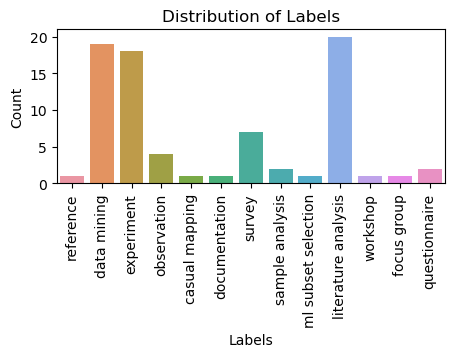

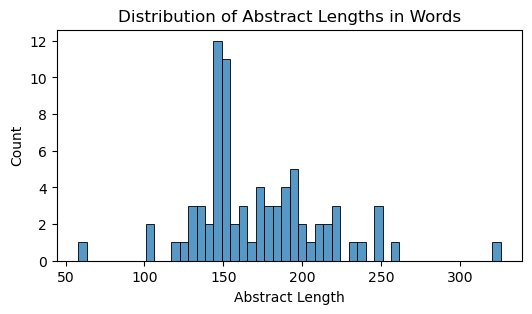

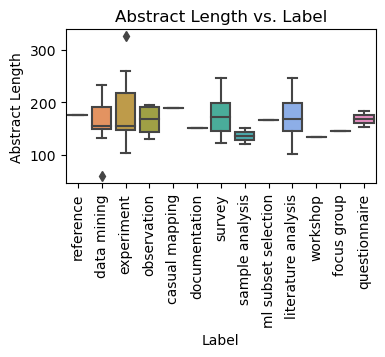

In [82]:
DatasetVisualizer.plot_all(datasets["ai_in_is_data_collection_techniques"])

## AI in IS Types

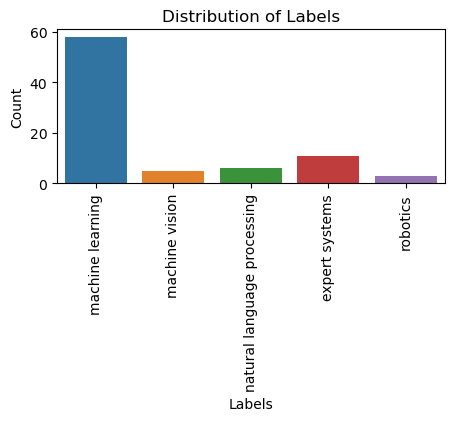

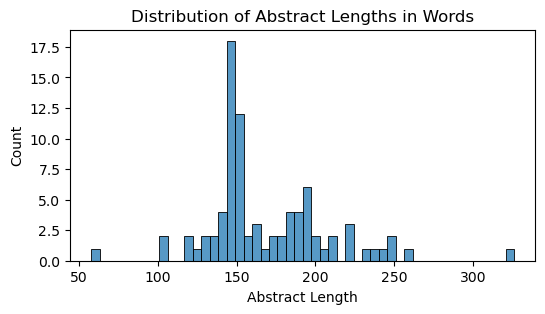

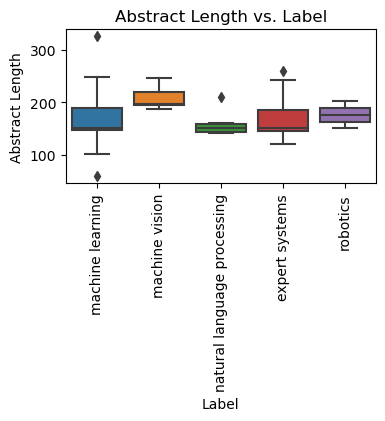

In [83]:
DatasetVisualizer.plot_all(datasets["ai_in_is_types"])

## AI in IS Data Collection Techniques

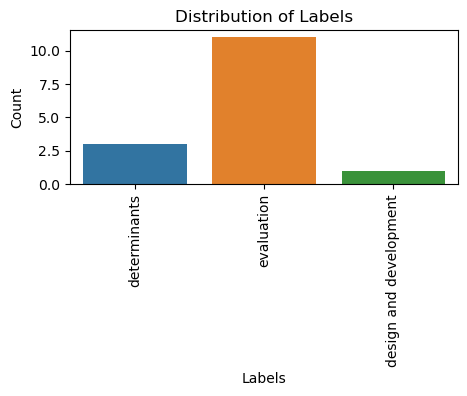

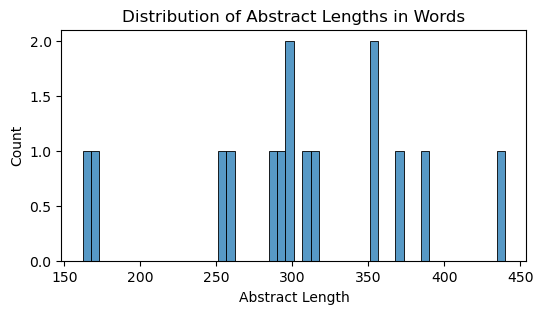

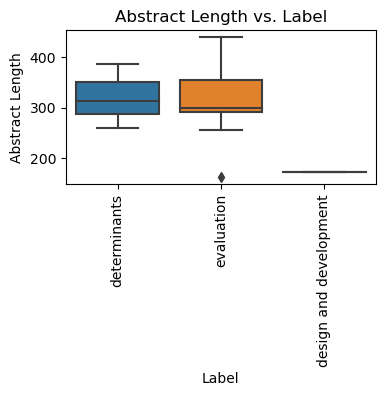

In [84]:
DatasetVisualizer.plot_all(datasets["data_completeness_in_healthcare"])

## Machine Learning in Business

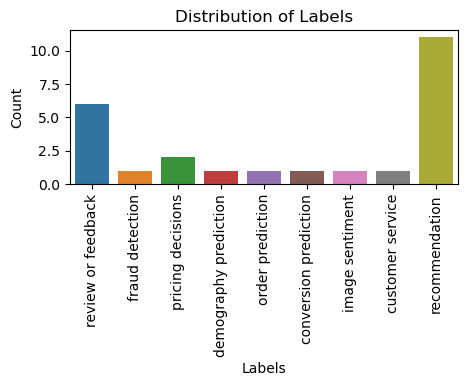

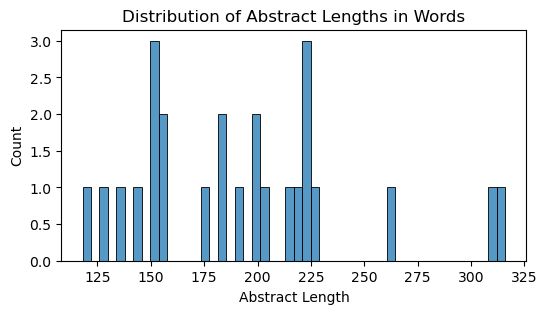

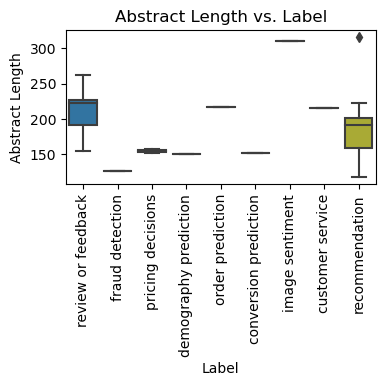

In [85]:
DatasetVisualizer.plot_all(datasets["machine_learning_in_business"])

## Search Engine Advertising

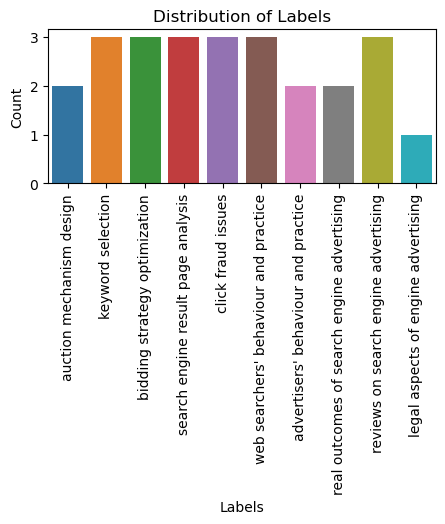

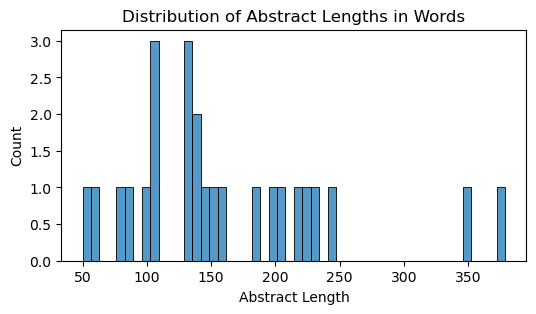

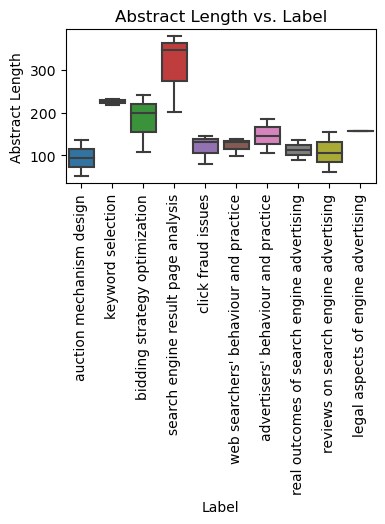

In [86]:
DatasetVisualizer.plot_all(datasets["search_engine_advertising"])

## Overview WI Theory Type

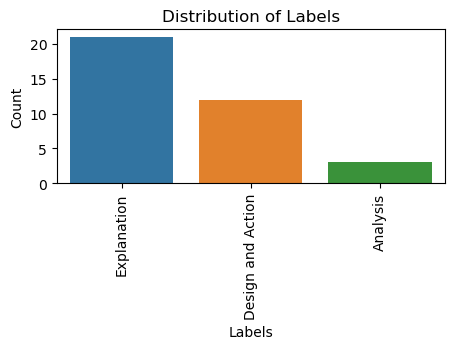

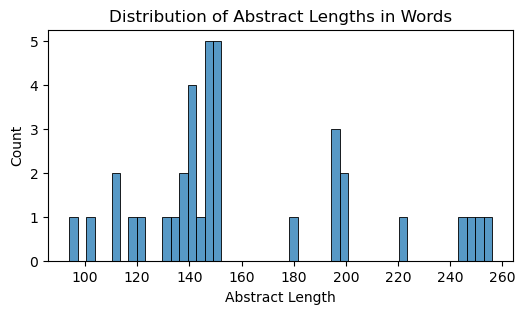

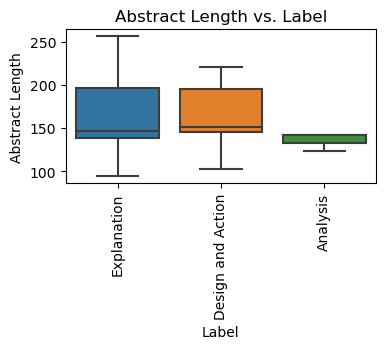

In [87]:
DatasetVisualizer.plot_all(datasets["overview_wi_theory_type"])

## Overview WI Research Method

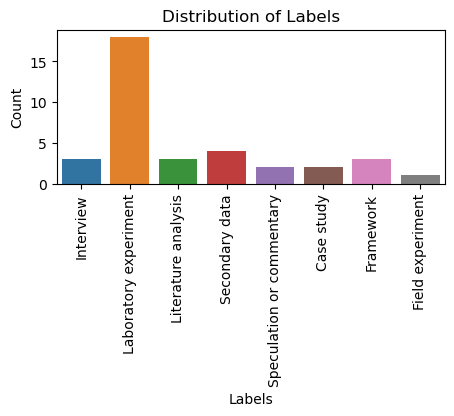

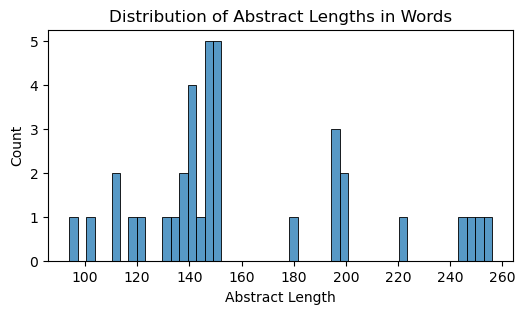

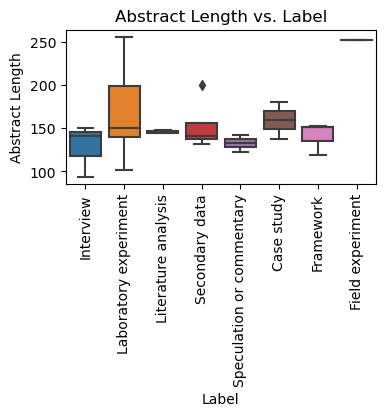

In [88]:
DatasetVisualizer.plot_all(datasets["overview_wi_research_method"])

## Overview MISQ Theory Types

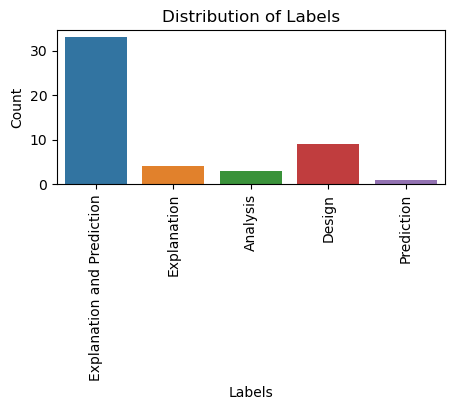

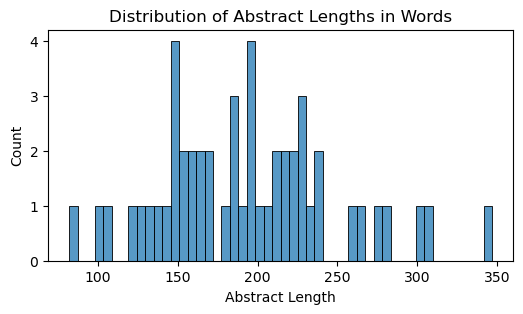

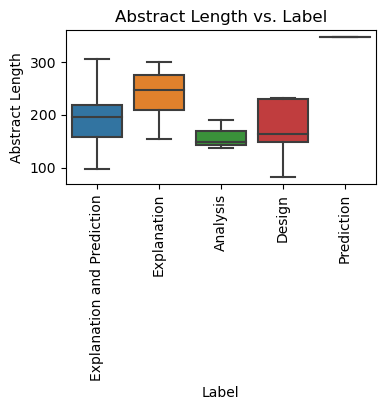

In [89]:
DatasetVisualizer.plot_all(datasets["overview_misq_theory_types"])

## Overview ESWA ML Approach

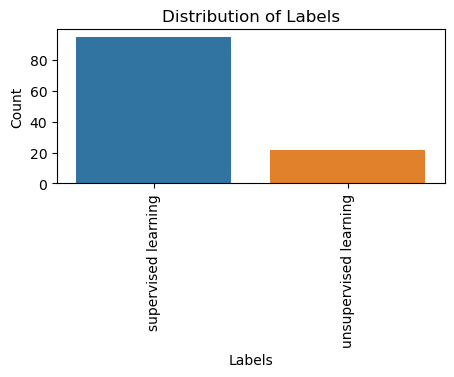

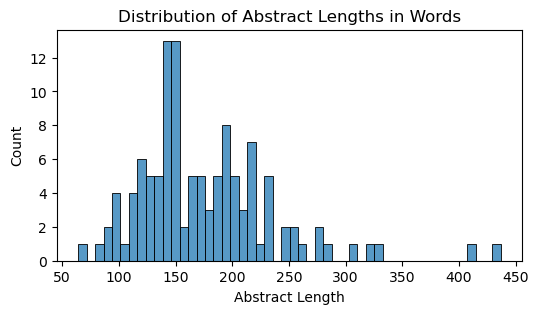

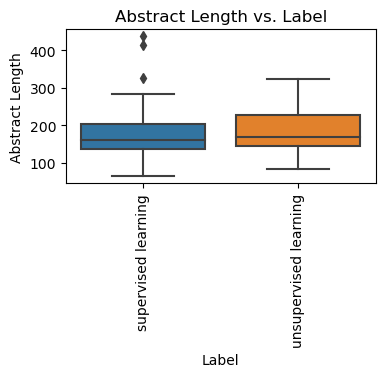

In [90]:
DatasetVisualizer.plot_all(datasets["overview_eswa_ml_approach"])

# Overall Evaluation